daten von disk laden

In [32]:
from keras.src.utils import image_dataset_from_directory
import os

dataset = image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=64,
        image_size=(128, 128),
        shuffle=True,
        interpolation="bilinear",
        crop_to_aspect_ratio=False,
        pad_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
        verbose=False,
    )
data_train = dataset[0]
data_val = dataset[1]

data_val, data_train

Using 7280 files for training.
Using 1820 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

data augmentation

In [33]:
import keras_cv
from keras.src.layers import RandomFlip, RandomContrast, RandomBrightness
from keras.src.utils import to_categorical
from keras import Sequential

preprocessing_layer = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.2),
        RandomBrightness(0.2),
])
data_train = data_train.map(lambda x, y: (preprocessing_layer(x), to_categorical(y, num_classes=7)))
data_val = data_val.map(lambda x, y: (preprocessing_layer(x), to_categorical(y, num_classes=7)))

data_train, data_val

(<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>)

plot data

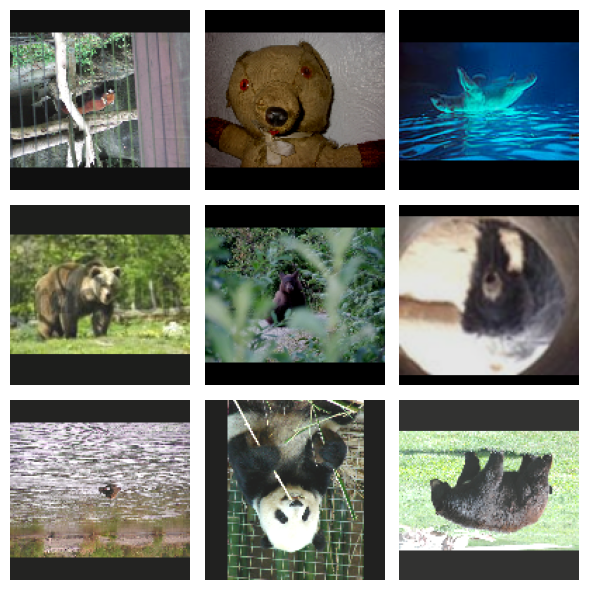

In [34]:
from keras_cv.src.visualization import plot_image_gallery

batch = next(iter(data_train.take(1)))
images, labels = batch
plot_image_gallery(
    batch[0],
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

train cnn

In [35]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import Sequential

model = Sequential([
    Conv2D(32, (4, 4), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(7, activation='softmax'),
])
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 125, 125, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 59, 59, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │        44,807 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,951 (2.80 MB)

 Trainable params: 734,951 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from livelossplot import PlotLossesKeras

history = model.fit(
    x=data_train,
    validation_data=data_val,
    epochs=5,
    callbacks=[PlotLossesKeras()],
)

Epoch 1/5
  2/114 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.1797 - loss: 33.0199


KeyboardInterrupt



In [37]:
import tensorflow as tf; print(tf.__version__)
import keras as kr; print(kr.__version__)

2.16.1
3.3.3
